 26%|██▌       | 2613/10000 [00:00<00:00, 26120.31it/s]

[-0.18235661  0.02480332 -0.56519917 -0.04940947  0.08176488]


 12%|█▏        | 1223/10000 [00:00<00:00, 12229.49it/s]

[-0.30431249  0.07861906 -0.10886183  0.41272941  0.94692284  0.46109969
 -0.63125511 -0.44600355  0.55719789]


 25%|██▍       | 2472/10000 [00:00<00:00, 12267.62it/s]

[ 0.0525291  -0.00474319 -0.1822104   0.02735217  0.05836296  0.02157392
  0.11509354 -0.04156695  0.0562168  -0.48790513  0.05866479]


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


[-0.13674593 -0.16443351 -0.20687422 -0.2069261  -0.20734087 -0.30000612
 -0.32012775 -0.35296553 -0.45424905 -0.44555798 -0.00236602  0.02280958
  0.0303547   0.0728728   0.08469949  0.0664101   0.07641014  0.10250463
  0.11336964  0.15544751  0.14601227  0.11601353  0.05114514  0.05766636
  0.03391074  0.03621139 -0.01793877 -0.03631947  0.07525574  0.05139779
  0.09311945 -0.26303299  0.2574648 ]


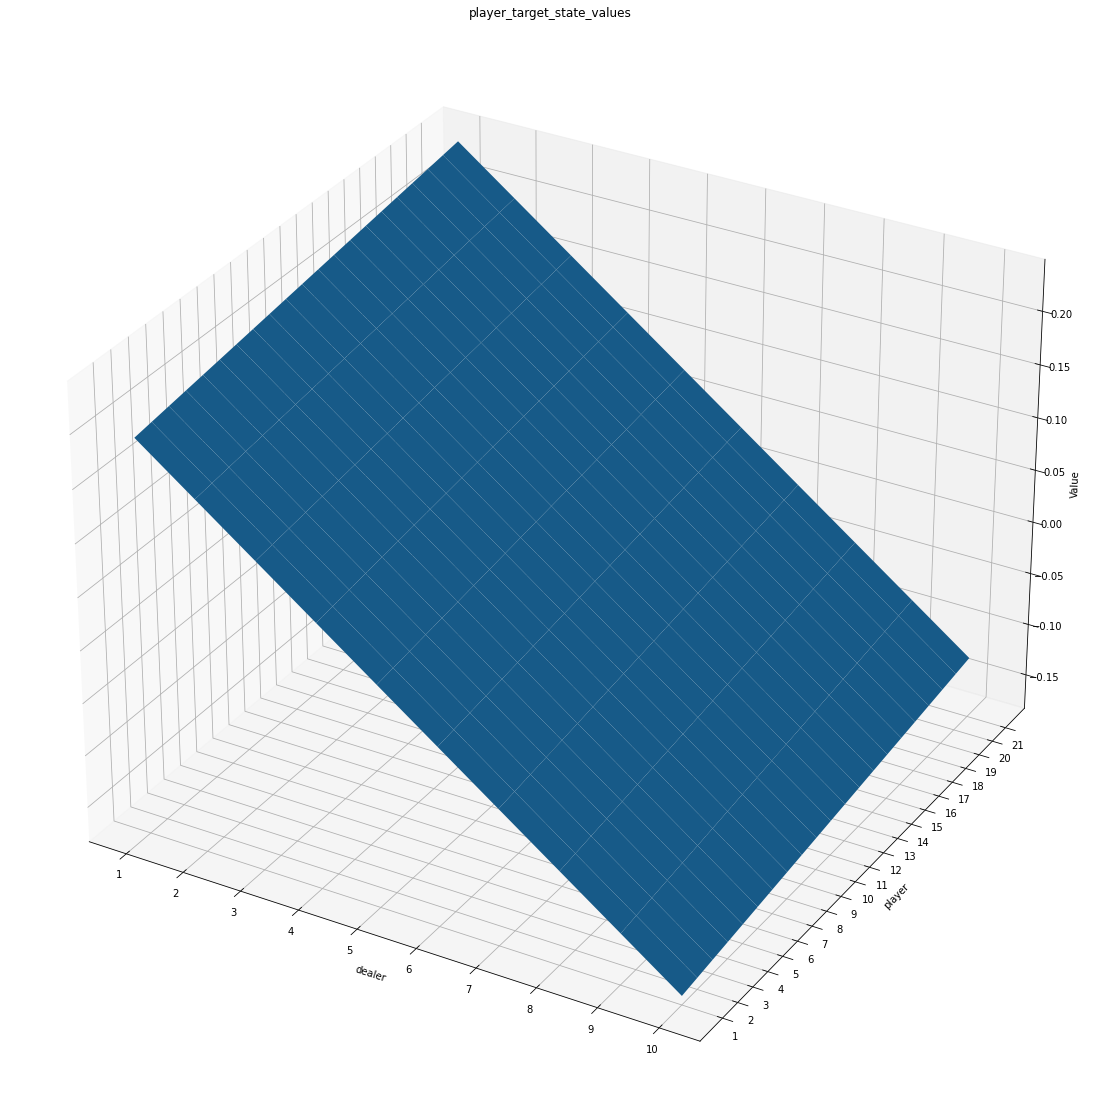

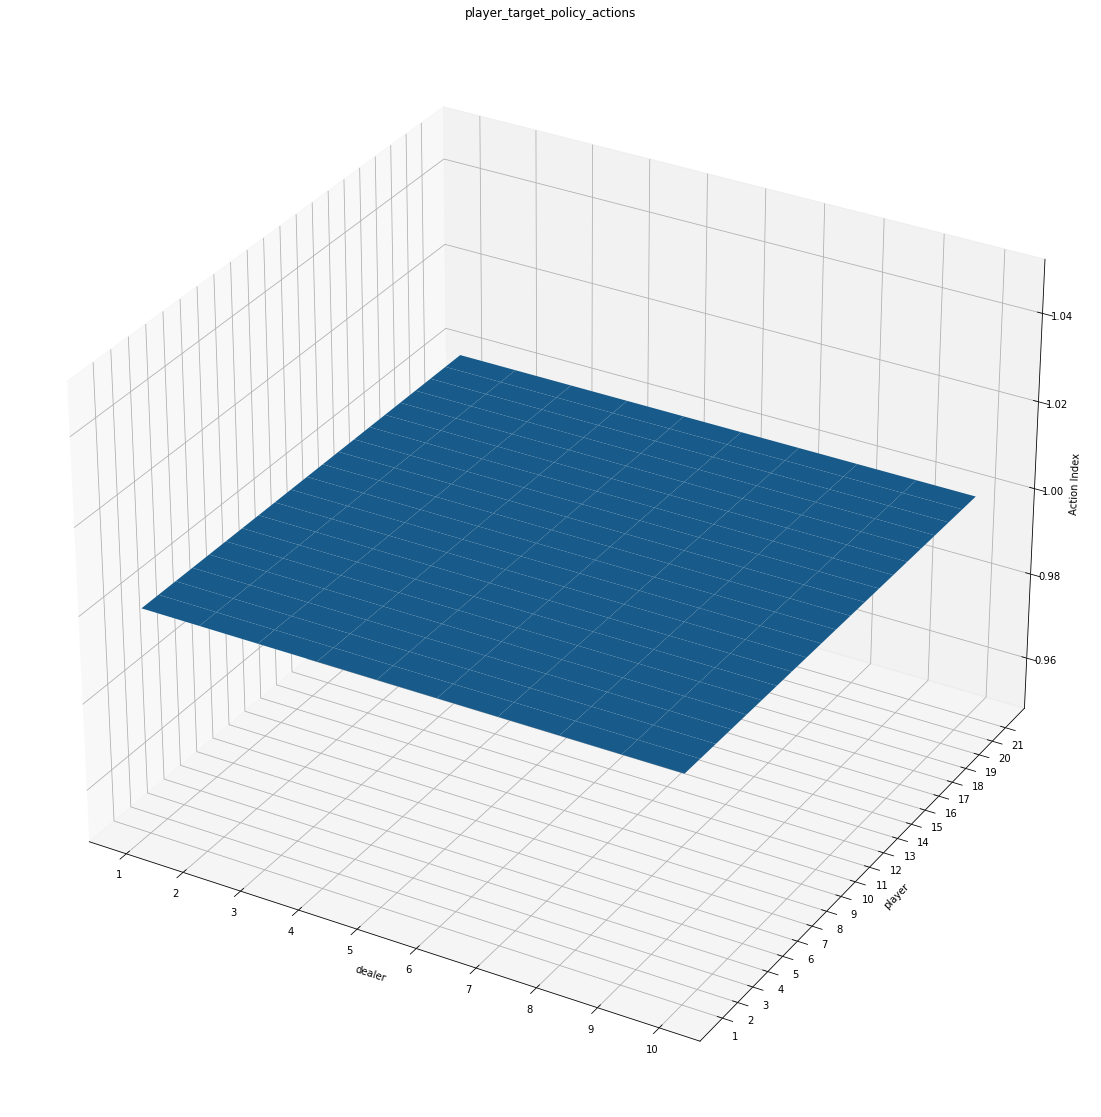

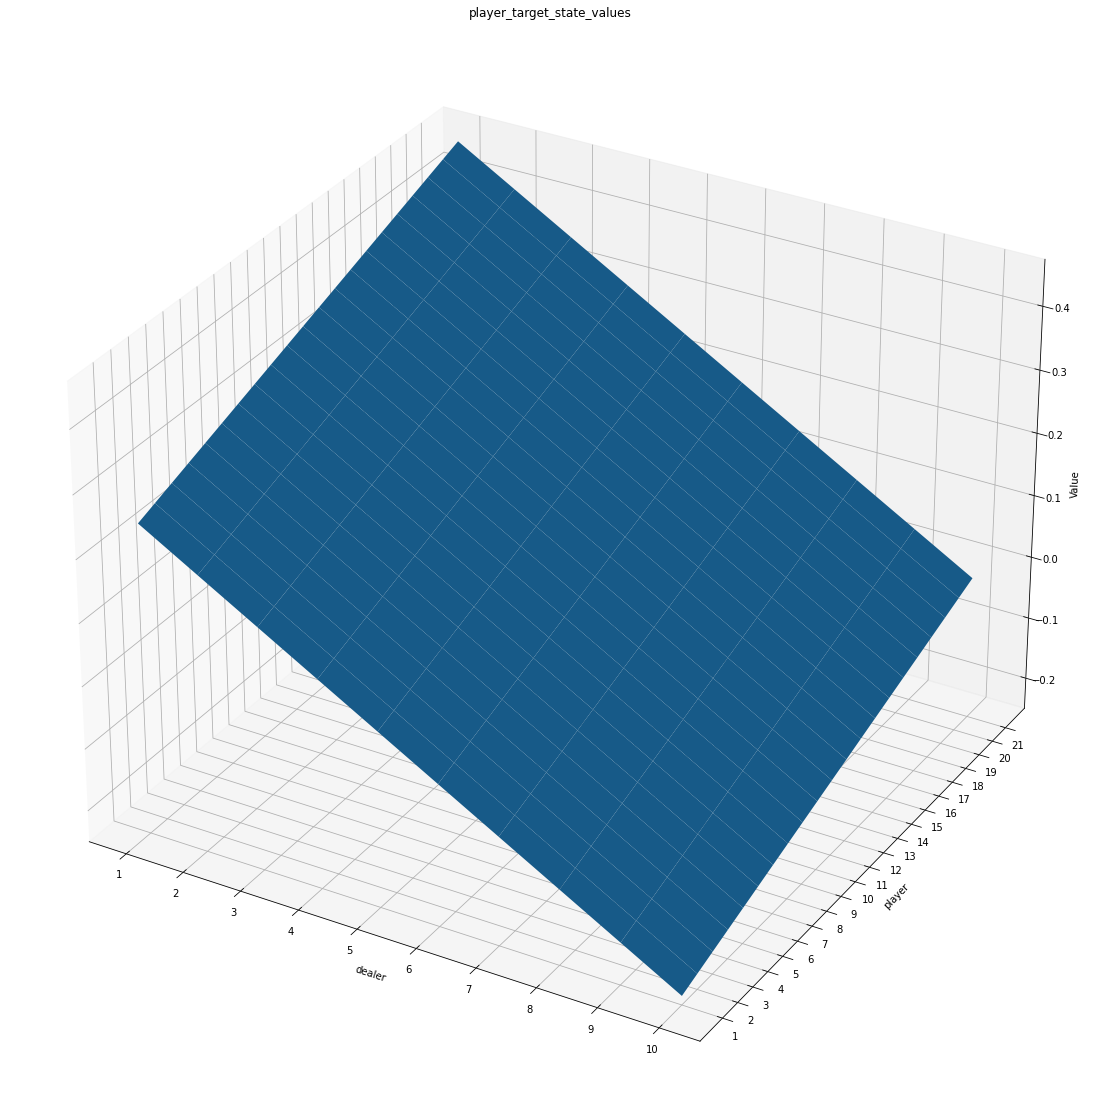

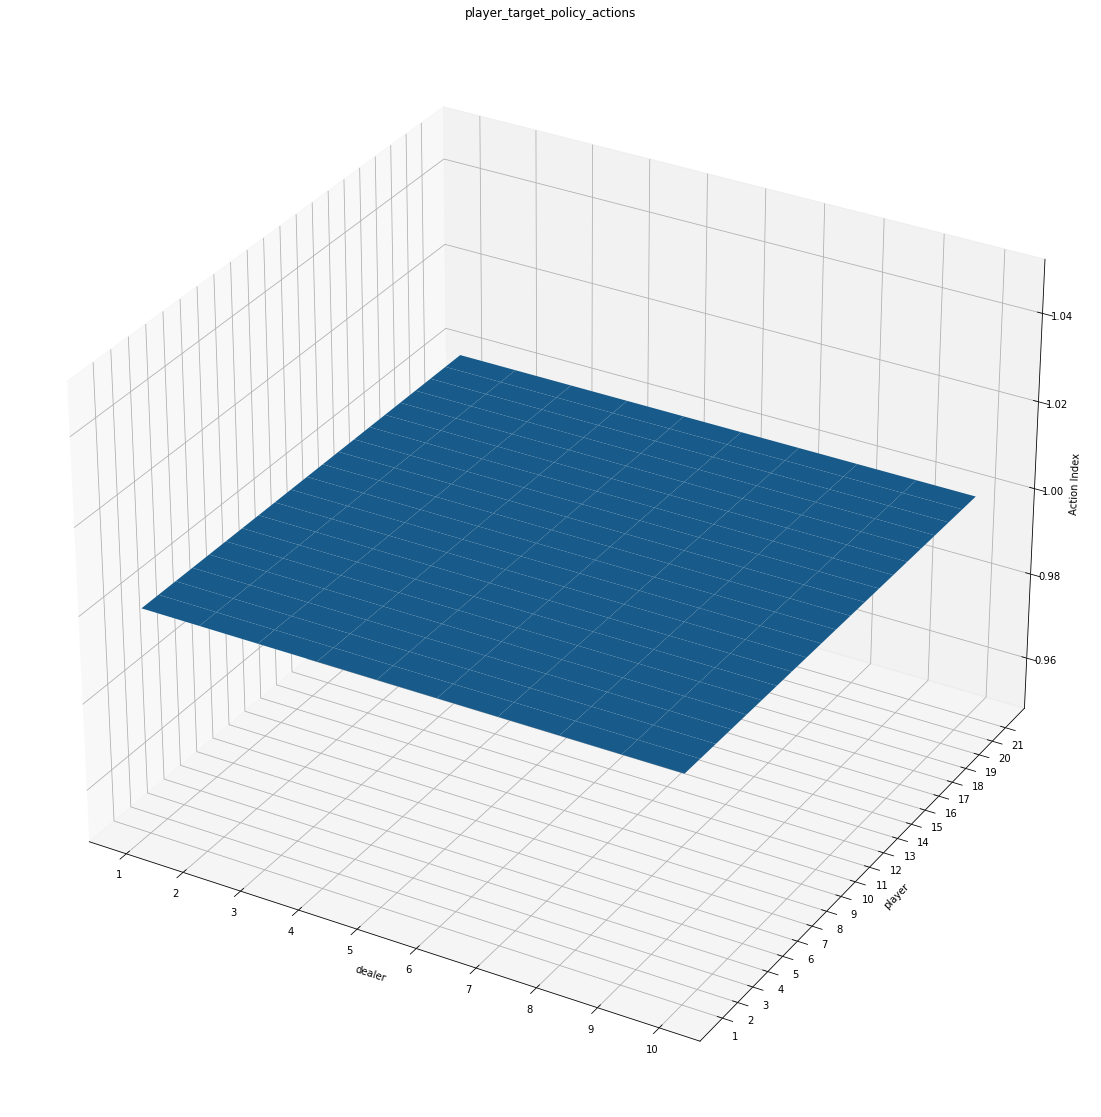

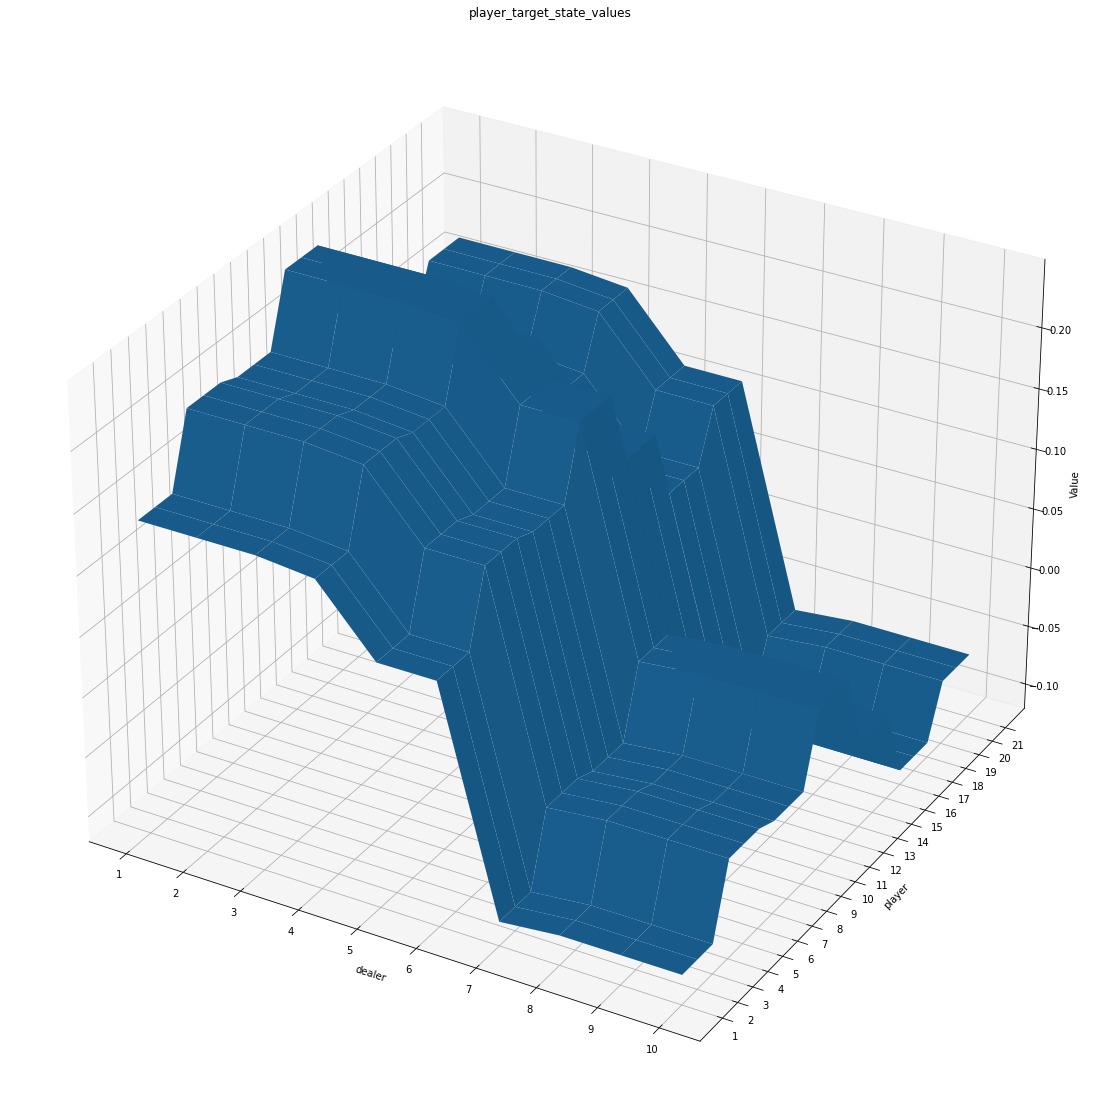

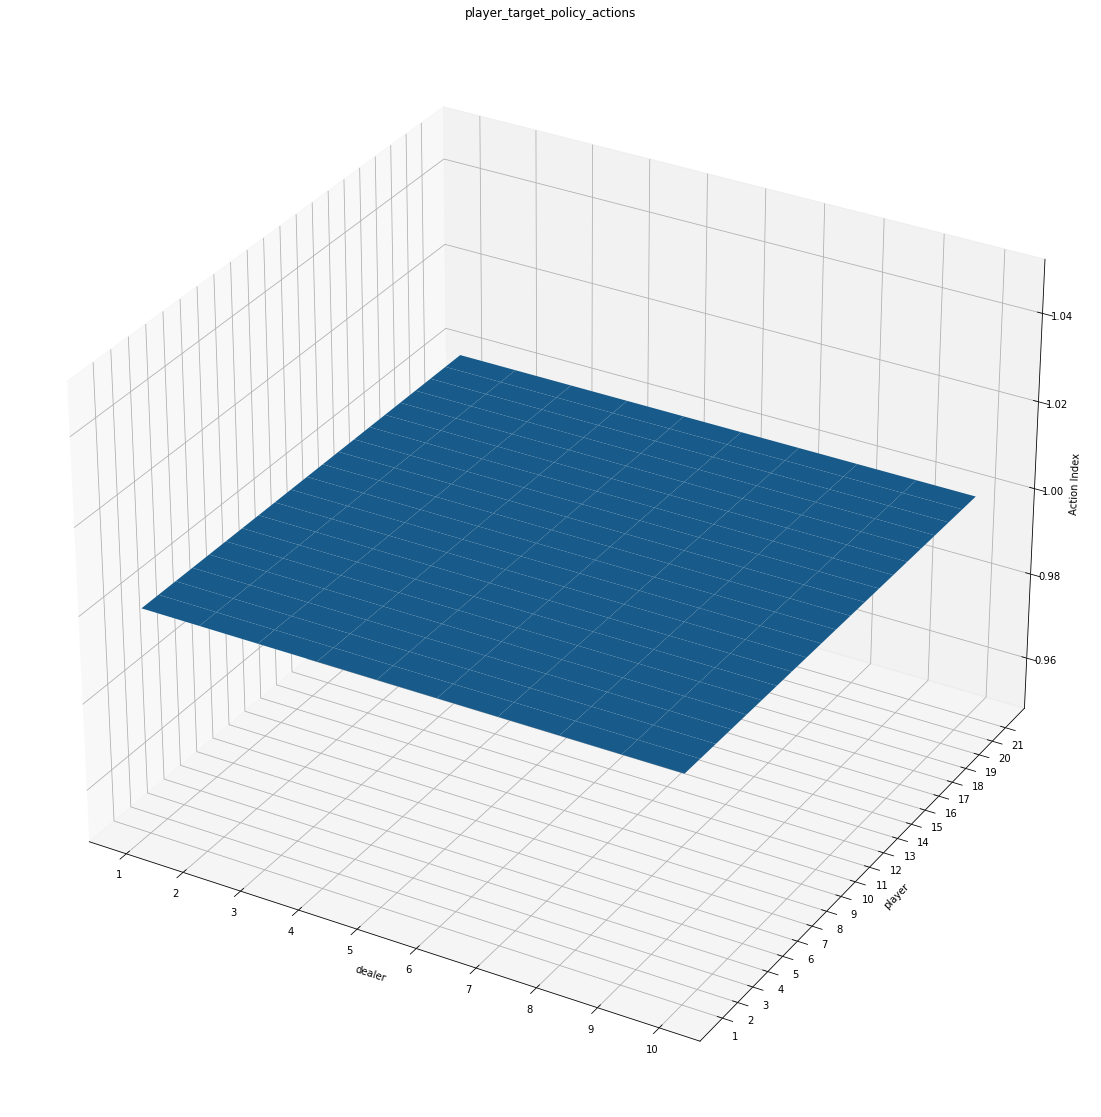

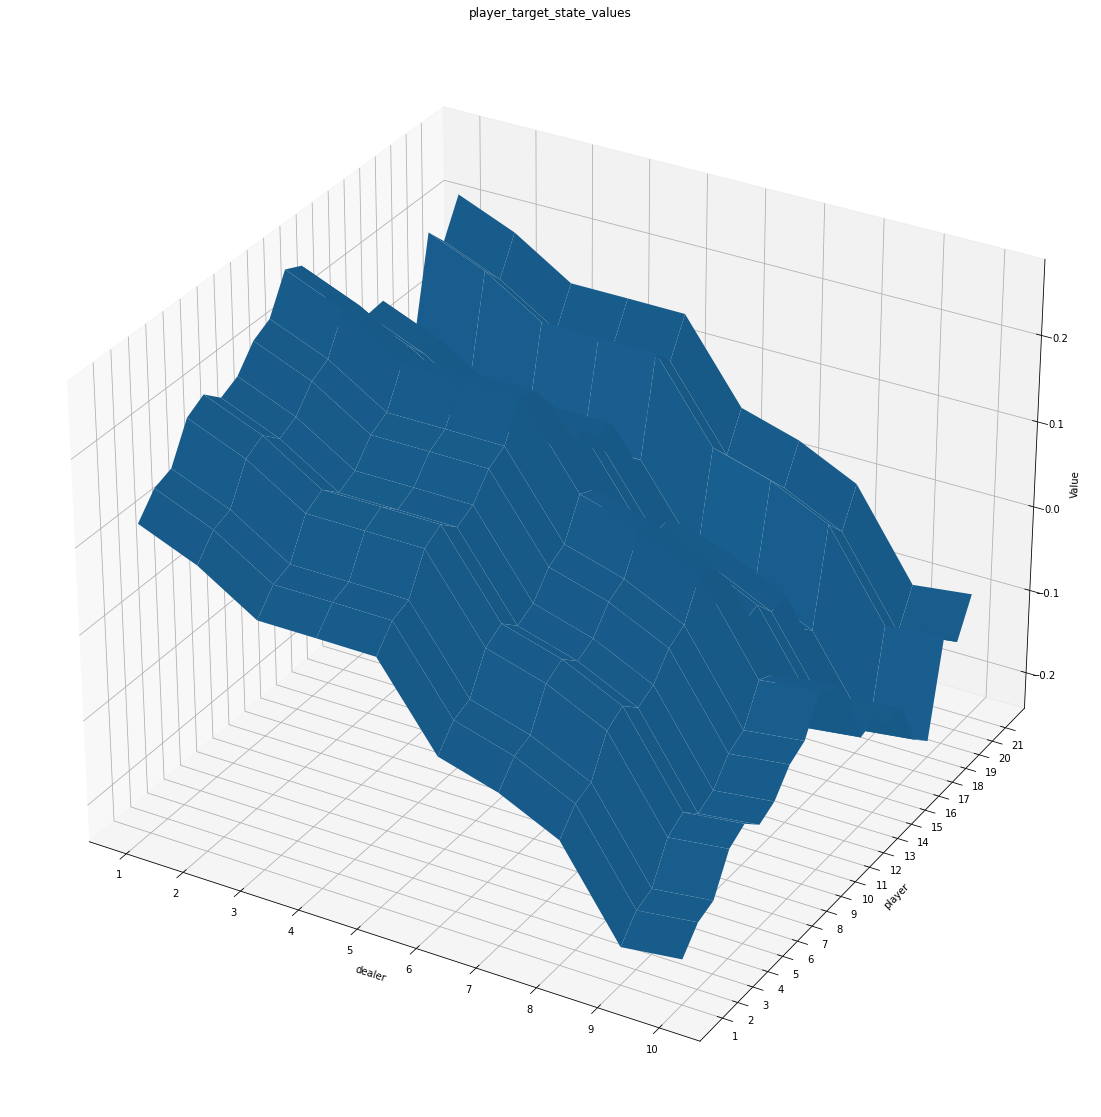

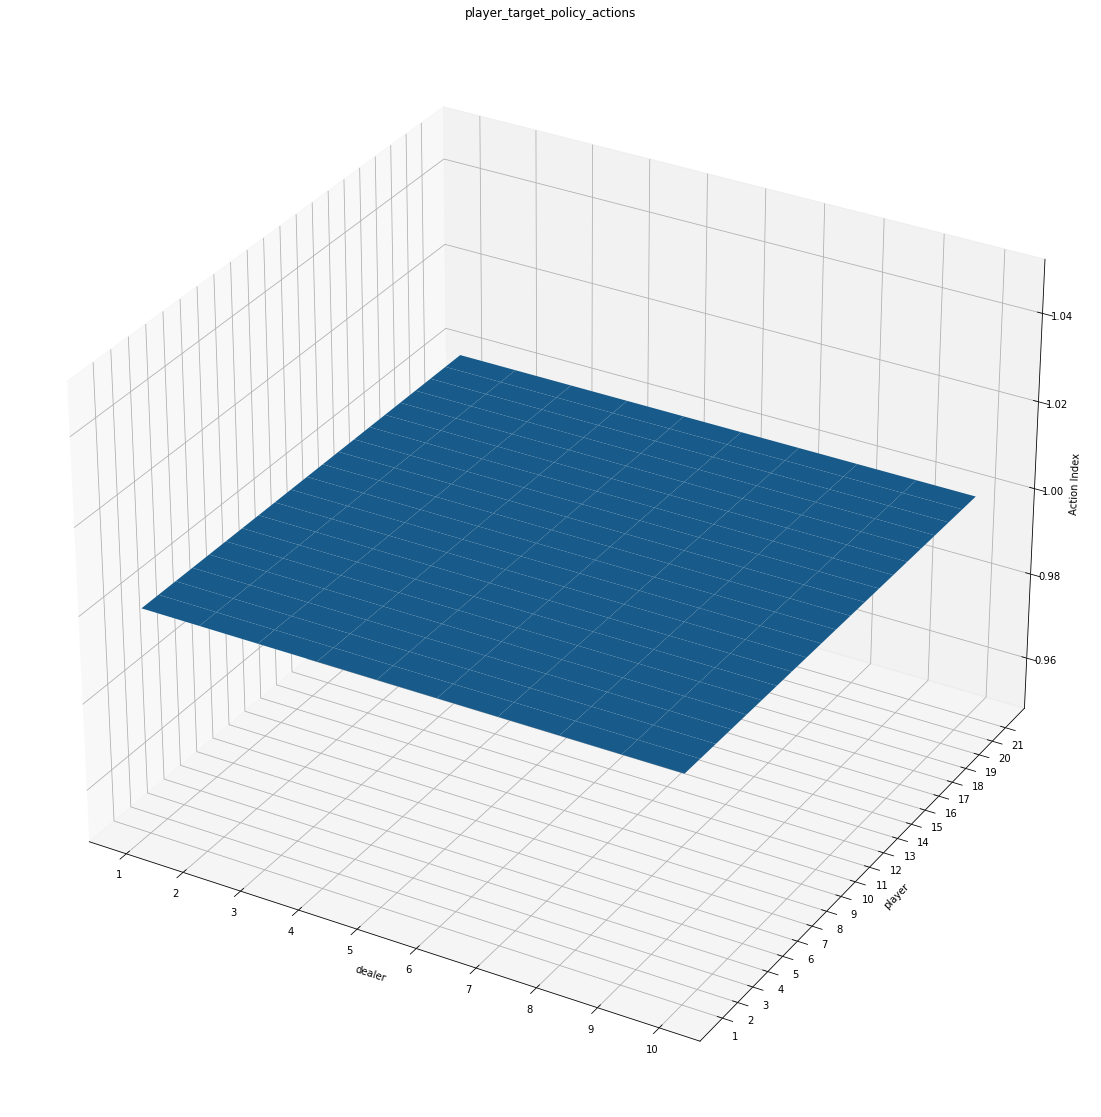

In [ ]:
# TASK:
# - check binary_feature/numeric_feature ~ convergence
#
# PROCESS;
# - sample EPISODES experiences with with different feature_functions
# - replay experience of EPOCH to fit with value approximator with
#   LEARNING_RATE
# - check accuracy history
#
# RESULTS:
# - numeric_feature - best accuracy ~ 0.25
# - binary_feature - best accuracy ~ 0.30
#
# INTERPRETATION:
# - numeric_feature is creating a flat surface, while binary_feature is
#   creating a grided surface; the true value surface in this case is closer
#   to 2 surfaces combined by conditions, neural networks are expected to
#   have better accuracy
# - performance of features are dependant on particular models, in this case
#   numeric_feature shows better accuracy than binary_feature
#
# RUN:
# %%
import sys

sys.path.append("../")

from tqdm import trange
from random import shuffle

from src.module.model_free_agent import ModelFreeAgent

from src.easy_21.game import playout, ACTIONS, STATE_LABELS, PLAYER_STATES
from src.easy_21.feature_function import (
    # numeric_feature,
    numeric_binary_feature,
    bounded_numeric_binary_feature,
    overlapped_binary_feature,
    full_binary_feature,
)

#
# hyperparameters and agent config
#
EPISODES = int(1e4)
EPOCH = 50
LEARNING_RATE = 0.001

PLAYER = ModelFreeAgent(
    "player",
    ACTIONS,
    STATE_LABELS,
    PLAYER_STATES,
    state_compressor=full_binary_feature,
)
PLAYER.load_optimal_state_values()

PLAYER.target_state_value_store.metrics_methods[
    "accuracy"
] = PLAYER.target_state_value_store_accuracy_to_optimal

#
# process
#

for feature_function in [
    # numeric_feature,
    numeric_binary_feature,
    bounded_numeric_binary_feature,
    overlapped_binary_feature,
    full_binary_feature,
]:

    PLAYER.action_value_store.reset()
    PLAYER.action_value_store.feature_function = feature_function

    experiences = [
        playout(player_policy=PLAYER.e_greedy_policy)[0] for _ in trange(EPISODES)
    ]

    for _ in trange(EPOCH):
        shuffle(experiences)
        PLAYER.forward_td_lambda_learning_offline_batch(
            experiences, step_size=LEARNING_RATE
        )

        PLAYER.target_state_value_store.record("accuracy", log=False)

    PLAYER.target_state_value_store.stack_metrics_history("accuracy")

    PLAYER.set_target_value_stores()
    PLAYER.plot_2d_target_value_stores()

    print(PLAYER.action_value_store.weights)


labels = [
    # "numeric_feature",
    "numeric_binary_feature",
    "bounded_numeric_binary_feature",
    "overlapped_binary_feature",
    "full_binary_feature",
]
PLAYER.target_state_value_store.plot_metrics_history_stack(
    "accuracy",
    labels=labels,
)
